<a href="https://colab.research.google.com/github/Nebil1/UNDP-FTL-AI/blob/main/Task_1_%26_2_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 1**

- Supervised Learning

- Please collapse task 1 to access task 2

##Import Libraries

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import (
    accuracy_score, precision_score,
    recall_score, classification_report,
    confusion_matrix, roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier

 ## Load data

In [177]:
url = "https://drive.google.com/uc?id=1zIk9JOdJEu9YF7Xuv2C8f2Q8ySfG3nHd"
df = pd.read_csv(url)

Check data

In [178]:
df.head()

,Country or Administrative area,Area [km2],Coast length [km],Rainfall [mm year -1],Factor L/A [-],Factor (L/A) *P [-],P[E] [%],MPW (metric tons year -1),M[E] (metric tons year -1),Ratio Me/MPW,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,Albania,28'486,362,1'117,0.0100,14.0,1.56%,69'833,1'565,2.24%,NaN,NaN,NaN,NaN
1,Algeria,2'316'559,998,80,0.0004,0.0,0.09%,764'578,5'774,0.76%,NaN,NaN,NaN,NaN
2,Angola,1'247'357,1'600,1'025,0.0010,1.0,0.09%,236'946,860,0.36%,NaN,NaN,NaN,NaN
3,Antigua and Barbuda,443,153,996,0.3000,344.0,3.08%,627,2,0.29%,NaN,NaN,NaN,NaN
4,Argentina,2'779'705,4'989,567,0.0020,1.0,0.26%,465'808,4'137,0.89%,NaN,NaN,NaN,NaN


## Clean the data

Drop Empty Columns

In [179]:
df = df.drop(columns=[c for c in df.columns if c.startswith("Unnamed")])
print("Shape after drop:", df.shape)
df.head()

Shape after drop: (165, 10)


,Country or Administrative area,Area [km2],Coast length [km],Rainfall [mm year -1],Factor L/A [-],Factor (L/A) *P [-],P[E] [%],MPW (metric tons year -1),M[E] (metric tons year -1),Ratio Me/MPW
0,Albania,28'486,362,1'117,0.0100,14.0,1.56%,69'833,1'565,2.24%
1,Algeria,2'316'559,998,80,0.0004,0.0,0.09%,764'578,5'774,0.76%
2,Angola,1'247'357,1'600,1'025,0.0010,1.0,0.09%,236'946,860,0.36%
3,Antigua and Barbuda,443,153,996,0.3000,344.0,3.08%,627,2,0.29%
4,Argentina,2'779'705,4'989,567,0.0020,1.0,0.26%,465'808,4'137,0.89%


In [180]:
def clean_numeric(col):
    return (
        col
        .astype(str)
        # keep only digits
        .str.replace(r'[^\d.]', '', regex=True)

        # turn empty strings into NaN
        .replace('', np.nan)

        # cast to float
        .astype(float)
    )

Then apply to every non-country column

In [181]:
for c in df.columns:
    if c != 'Country or Administrative area':
        df[c] = clean_numeric(df[c])

Check the data types

In [182]:
print(df.dtypes)

Country or Administrative area     object
Area [km2]                        float64
Coast length [km]                 float64
Rainfall [mm year -1]             float64
Factor L/A [-]                    float64
Factor (L/A) *P [-]               float64
P[E] [%]                          float64
MPW (metric tons year -1)         float64
M[E] (metric tons year -1)        float64
Ratio Me/MPW                      float64
dtype: object


## Fill Missing Values

In [183]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
for c in numeric_cols:
    roll = df[c].rolling(window=3, center=True, min_periods=1).mean()
    mask = df[c].isna()
    df.loc[mask, c] = roll[mask]

Confirm no NaNs remain


In [184]:
print(df[numeric_cols].isna().sum())

Area [km2]                    0
Coast length [km]             0
Rainfall [mm year -1]         0
Factor L/A [-]                0
Factor (L/A) *P [-]           0
P[E] [%]                      0
MPW (metric tons year -1)     0
M[E] (metric tons year -1)    0
Ratio Me/MPW                  0
dtype: int64


## Label the data

Create binary label (0=high>6008, 1=low≤6008)

In [185]:
col = 'M[E] (metric tons year -1)'
df['plastic_contribution'] = (df[col] <= 6008).astype(int)

In [186]:
print(df['plastic_contribution'].value_counts())

plastic_contribution
1    149
0     16
Name: count, dtype: int64


Build feature matrix X and target y

In [187]:
X = df.drop([col, 'plastic_contribution', 'Country or Administrative area'], axis=1, errors='ignore')
X = X.select_dtypes(include=[np.number])
y = df['plastic_contribution']
print("X shape:", X.shape, "  y dist:\n", y.value_counts())

X shape: (165, 8)   y dist:
 plastic_contribution
1    149
0     16
Name: count, dtype: int64


## Split data into train/test

In [188]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (132, 8) Test: (33, 8)


## Scale features

In [189]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## Train logistic regression model

In [190]:
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

## Evaluate the model

In [191]:
y_pred = model.predict(X_test_scaled)

In [192]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy : 0.8181818181818182
Precision: 0.9285714285714286
Recall   : 0.8666666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.93      0.87      0.90        30

    accuracy                           0.82        33
   macro avg       0.56      0.60      0.57        33
weighted avg       0.86      0.82      0.84        33



## Visualizations

High vs Low Contribution

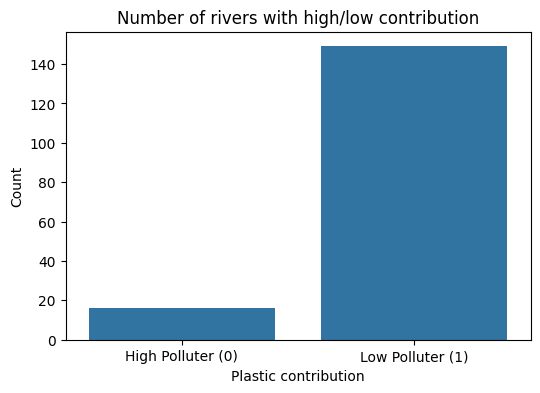

In [193]:
plt.figure(figsize=(6,4))
sns.countplot(x="plastic_contribution", data=df)
plt.xticks([0,1], ["High Polluter (0)","Low Polluter (1)"])
plt.xlabel("Plastic contribution")
plt.ylabel("Count")
plt.title("Number of rivers with high/low contribution")
plt.show()

Confusion matrix

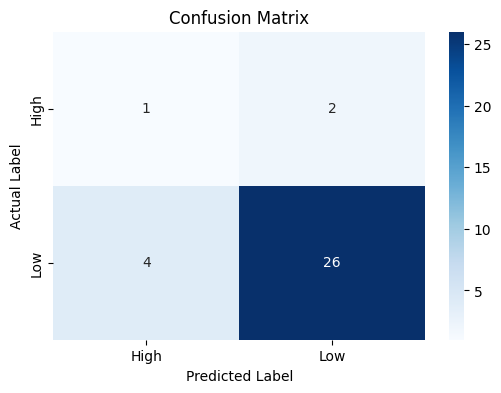

In [194]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["High","Low"],
            yticklabels=["High","Low"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

 ROC/AUC

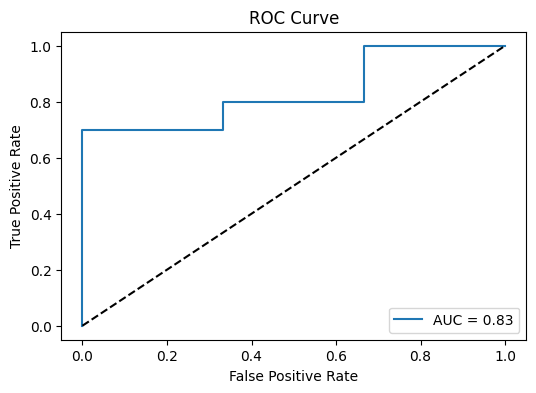

In [195]:
y_score = model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(loc='lower right')
plt.show()

## Extra Challenge – Top Predictors

Logistic Regression coefficients

Top 10 LogReg predictors:
 MPW (metric tons year -1)    3.249402
Rainfall [mm year -1]        1.255689
Factor (L/A) *P [-]          0.876547
P[E] [%]                     0.543926
Area [km2]                   0.486232
Factor L/A [-]               0.440240
Coast length [km]            0.300914
Ratio Me/MPW                 0.107177
dtype: float64


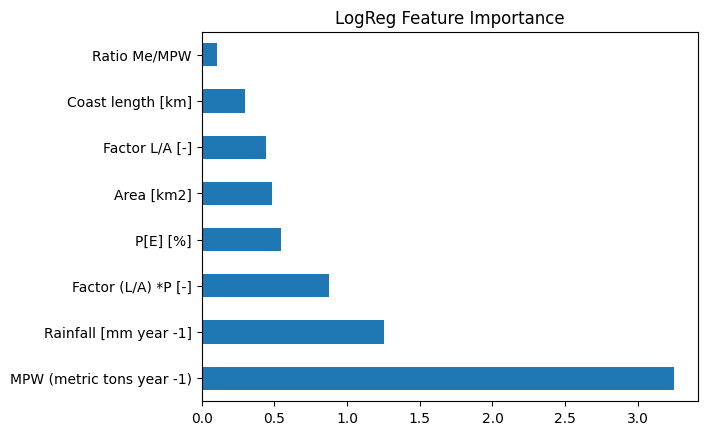

In [196]:
coef = pd.Series(model.coef_[0], index=X.columns)
top_coef = coef.abs().sort_values(ascending=False).head(10)
print("Top 10 LogReg predictors:\n", top_coef)
top_coef.plot.barh(title="LogReg Feature Importance"); plt.show()

Random Forest importances

Top 10 RF predictors:
 MPW (metric tons year -1)    0.367404
Area [km2]                   0.123950
Coast length [km]            0.120711
Ratio Me/MPW                 0.115982
P[E] [%]                     0.102601
Rainfall [mm year -1]        0.094914
Factor L/A [-]               0.041540
Factor (L/A) *P [-]          0.032898
dtype: float64


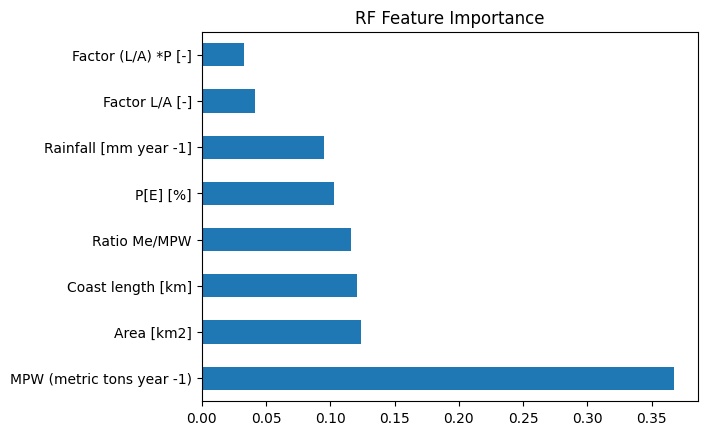

In [197]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train)
imp = pd.Series(rf.feature_importances_, index=X.columns)
top_imp = imp.sort_values(ascending=False).head(10)
print("Top 10 RF predictors:\n", top_imp)
top_imp.plot.barh(title="RF Feature Importance"); plt.show()

# **Task 2**

- Unsupervised Learning

In [198]:
df.head()

,Country or Administrative area,Area [km2],Coast length [km],Rainfall [mm year -1],Factor L/A [-],Factor (L/A) *P [-],P[E] [%],MPW (metric tons year -1),M[E] (metric tons year -1),Ratio Me/MPW,plastic_contribution
0,Albania,28486.0,362.0,1117.0,0.0100,14.0,1.56,69833.0,1565.0,2.24,1
1,Algeria,2316559.0,998.0,80.0,0.0004,0.0,0.09,764578.0,5774.0,0.76,1
2,Angola,1247357.0,1600.0,1025.0,0.0010,1.0,0.09,236946.0,860.0,0.36,1
3,Antigua and Barbuda,443.0,153.0,996.0,0.3000,344.0,3.08,627.0,2.0,0.29,1
4,Argentina,2779705.0,4989.0,567.0,0.0020,1.0,0.26,465808.0,4137.0,0.89,1


Data prep


In [199]:
df2 = df.dropna().copy()
X2 = df2.select_dtypes(include="number").drop(columns=["plastic_contribution"])
print(df2.isna().sum())

Country or Administrative area    0
Area [km2]                        0
Coast length [km]                 0
Rainfall [mm year -1]             0
Factor L/A [-]                    0
Factor (L/A) *P [-]               0
P[E] [%]                          0
MPW (metric tons year -1)         0
M[E] (metric tons year -1)        0
Ratio Me/MPW                      0
plastic_contribution              0
dtype: int64


In [200]:
from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

Fit K-Means (k=2)

In [201]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
df2["cluster"] = kmeans.fit_predict(X2_scaled)

In [207]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_true = df2["plastic_contribution"]
y_pred = df2["cluster"]

print("\nAccuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))


Accuracy: 0.7116564417177914

Classification Report:
               precision    recall  f1-score   support

           0      0.122     0.312     0.175        16
           1      0.910     0.755     0.825       147

    accuracy                          0.712       163
   macro avg      0.516     0.534     0.500       163
weighted avg      0.832     0.712     0.761       163



###Visualize clusters with PCA

Cluster 0: high-polluter

Cluster 1: low-polluter


In [203]:
# Quick Decision Tree to rank feature importances

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X2_scaled, df2["cluster"])

importances = pd.Series(dt.feature_importances_, index=X2.columns)
print("\nTop features driving the clustering:")
print(importances.sort_values(ascending=False).head())


Top features driving the clustering:
P[E] [%]               0.822094
Ratio Me/MPW           0.099804
Factor (L/A) *P [-]    0.078102
Area [km2]             0.000000
Coast length [km]      0.000000
dtype: float64


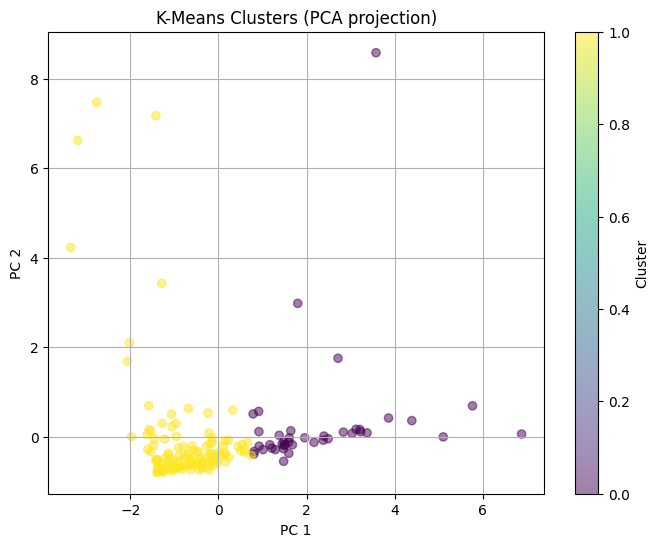

In [204]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    pcs2[:,0], pcs2[:,1],
    c=df2["cluster"],
    cmap="viridis",
    alpha=0.5
)
plt.title("K-Means Clusters (PCA projection)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

In [208]:
import plotly.express as px

fig = px.scatter(
    x=pcs2[:,0],
    y=pcs2[:,1],
    color=df2["cluster"].astype(str),
    hover_name=df2["Country or Administrative area"],
    title="K-Means Clusters (PCA) — hover for country",
    labels={"x":"PC 1","y":"PC 2","color":"Cluster"}
)
fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.show()

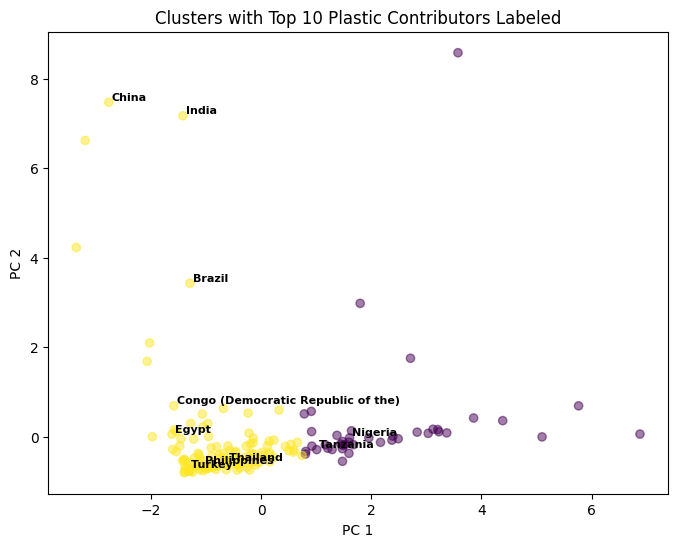

In [206]:
# top 10 polluters
top10 = df2.nlargest(10, "MPW (metric tons year -1)")

plt.figure(figsize=(8,6))
plt.scatter(pcs2[:,0], pcs2[:,1], c=df2["cluster"], cmap="viridis", alpha=0.5)

for _, row in top10.iterrows():
    i = row.name
    plt.text(pcs2[i,0]+0.05, pcs2[i,1]+0.05, row["Country or Administrative area"],
             fontsize=8, weight="bold")

plt.title("Clusters with Top 10 Plastic Contributors Labeled")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()